# Training for Movie Dataset

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [2]:
#Preprocessing function for dataframe, to be used later on
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.add('br')
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data Exploration

br is removed manually since it appears a lot

                                                text  label
0  Incredibly intriguing and captivating, I found...      1
1  Great movie! oh yeah! Full of energy, full of ...      1
2  I couldn't believe it when I put this movie in...      0
3  Not much to say on this one. A plot you can pr...      0
4  With the dialogue in the dubbed version of thi...      0
Class Distribution:
label
1    0.500375
0    0.499625
Name: proportion, dtype: float64


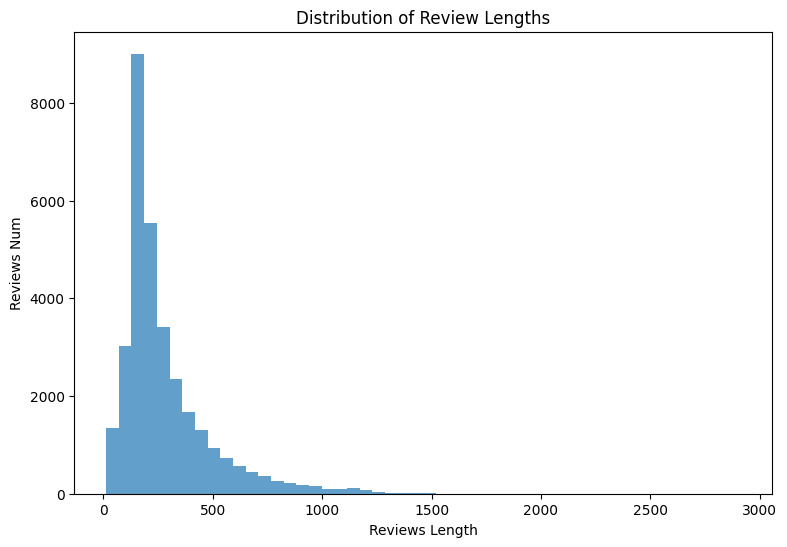

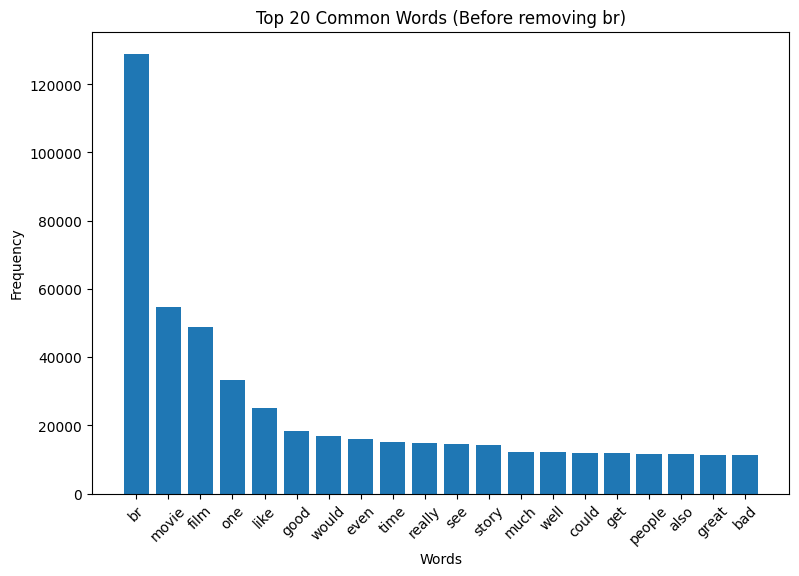

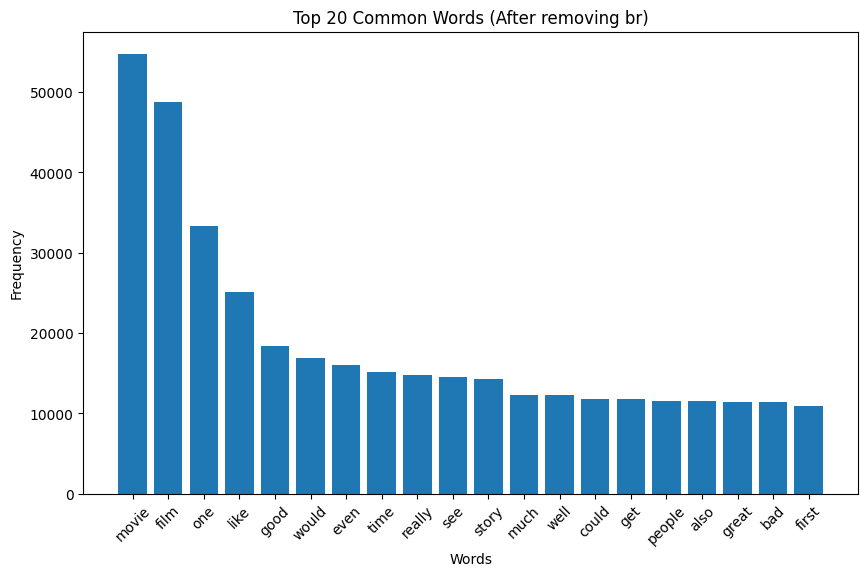

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize

train_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/movie_train.csv')
print(train_data.head())

print("Class Distribution:")
print(train_data['label'].value_counts(normalize=True))

review_lengths = train_data['text'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(9, 6))
plt.hist(review_lengths, bins=50, alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Reviews Length')
plt.ylabel('Reviews Num')
plt.show()

stop_words = set(stopwords.words('english'))
all_words = [word for review in train_data['text'] for word in word_tokenize(review.lower()) if word.isalpha() and word not in stop_words]

word_freq = Counter(all_words).most_common(20)

words, frequencies = zip(*word_freq)
plt.figure(figsize=(9, 6))
plt.bar(words, frequencies)
plt.title('Top 20 Common Words (Before removing br)')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

stop_words = set(stopwords.words('english'))
stop_words.add('br')
all_words = [word for review in train_data['text'] for word in word_tokenize(review.lower()) if word.isalpha() and word not in stop_words]

word_freq = Counter(all_words).most_common(20)

words, frequencies = zip(*word_freq)
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Top 20 Common Words (After removing br)')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


In [4]:
train_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/movie_train.csv')
test_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/movie_test.csv')

print(train_data.value_counts('label'))
print(test_data.value_counts('label'))

# Don't need to balance since data is already somewhat balanced

label
1    16012
0    15988
Name: count, dtype: int64
label
0    4031
1    3969
Name: count, dtype: int64


# Simple RNN

Epoch 1/5
200/200 [==============================] - 32s 153ms/step - loss: 0.5532 - accuracy: 0.6941 - val_loss: 0.3716 - val_accuracy: 0.8388
Epoch 2/5
200/200 [==============================] - 24s 120ms/step - loss: 0.2739 - accuracy: 0.8905 - val_loss: 0.3167 - val_accuracy: 0.8703
Epoch 3/5
200/200 [==============================] - 22s 111ms/step - loss: 0.1688 - accuracy: 0.9397 - val_loss: 0.3401 - val_accuracy: 0.8673
Epoch 4/5
200/200 [==============================] - 19s 94ms/step - loss: 0.0908 - accuracy: 0.9722 - val_loss: 0.4040 - val_accuracy: 0.8620
Epoch 5/5
250/250 [==============================] - 3s 13ms/step


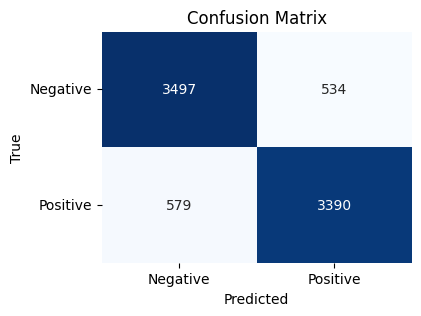

250/250 [==============================] - 2s 9ms/step


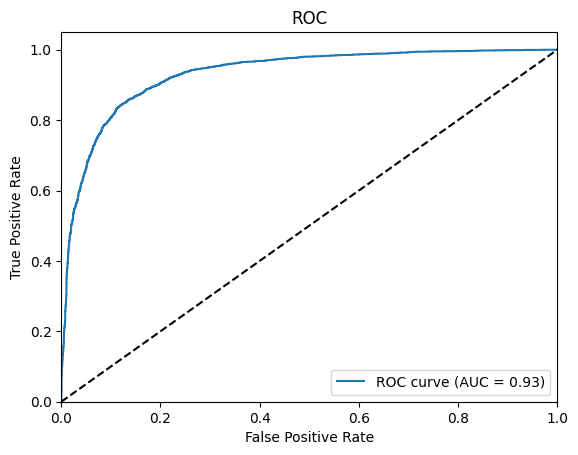

Accuracy: 0.8609, Precision: 0.8639, Recall: 0.8541, F1: 0.8590, AUC: 0.9309


In [31]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/movie_train.csv')
test_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/movie_test.csv')

train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)

#limit set to not run out of ram
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data['text'])
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

y_train = train_data['label'].values
y_test = test_data['label'].values

model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)
predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")


In [32]:
print(test_data[test_data['label']==1].iloc[3]['text'])

first trailer film viewed , curious angle storyline would take . plot one 's childhood self return present leaves open many options . Bruce Willis however superb job role given . surprised see well could act part . also good career move many others said seeing agree . film mainly remembering kid used , coming realization n't adult planned . wonderful story gripping tale makes us think . Usually scorn `` ... '' movies . example , Waterworld attempted answer question `` world covered water ... ? '' truthfully , nobody cared . movie however effects everyone theatre . True , young children may fully grasp idea growing dreams fizzle away , leaves great impact adults parents children . movie definitely worth seeing . Although , better second time around wo n't thinking much ( kid got , stuff ) relax fun . take something leave cinema . Take piece childhood 've forgotten enjoy .


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def adhoc_test_x(input_string, tokenizer):
  input_df = pd.DataFrame([input_string], columns=['text'])
  input_df['text'] = input_df['text'].apply(remove_stopwords)
  adhoc_test_sequences = tokenizer.texts_to_sequences(input_df['text'])
  adhoc_x_test = pad_sequences(adhoc_test_sequences, maxlen=100)
  return adhoc_x_test

In [13]:
### SAVE
import pickle

with open('movie_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('simple_rnn_movie')

### LOAD
from tensorflow.keras.models import load_model

with open('movie_tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

loaded_model = load_model('simple_rnn_movie')

In [16]:
# Test random string for Simple RNN

test_string_positive = '''
first trailer film viewed , curious angle storyline would take . plot one 's childhood self return present leaves open many options . Bruce Willis however superb job role given . surprised see well could act part . also good career move many others said seeing agree . film mainly remembering kid used , coming realization n't adult planned . wonderful story gripping tale makes us think . Usually scorn `` ... '' movies . example , Waterworld attempted answer question `` world covered water ... ? '' truthfully , nobody cared . movie however effects everyone theatre . True , young children may fully grasp idea growing dreams fizzle away , leaves great impact adults parents children . movie definitely worth seeing . Although , better second time around wo n't thinking much ( kid got , stuff ) relax fun . take something leave cinema . Take piece childhood 've forgotten enjoy .'''

test_string_negative = '''
m Iraq right job gives plenty time watching movies . also access plenty pirated movies , gem came along 11 movies , easily worst 've seen long time . 've seen reviews claim movie n't take seriously , really , think 's cover fact horrible . 's tongue cheek , writers really thought improving movie Blade . movie one notch Vampire Assassin , n't seen , recommend . least movie unbelievably bad 'll laugh harder thought possible . right cusp redeeming qualities ever . bad acting , cliché visual ( ie opening credits ) , adobe premier special effects . could n't even get blanks guns , may movie filmed , 're going use effects , make close accurate . cast , seems like went tae bo class picked first ugly chick walked . , like Ron Hall Vampire Assassin , n't let stunt folk act , ca n't . Also , comment `` return old vampire movies '' ... , 's . exactly new vampire movies . Buffy Vampire Slayer , Blade , Underworld , 're super star fighting vampires . newest vampire genre , bad blood , fake screams , cheesy acting . obviously anyone wrote good review somehow connected movie , friends cast . care , paid 33 cents . Anyway , wrap , someone first semester film school decided make movie , give credit 's better could . course also know ca n't make movies n't try . know watch movies though . work 12 hour nights , 6 days week , 've seen several thousand year 've bad half way hoping mortar attack .
'''

print("test_string_positive")
input_x_positive = adhoc_test_x(test_string_positive, loaded_tokenizer)
print(loaded_model.predict(input_x_positive).ravel())

print("test_string_negative")
input_x_negative = adhoc_test_x(test_string_negative, loaded_tokenizer)
print(loaded_model.predict(input_x_negative).ravel())

test_string_positive
1/1 [==============================] - 0s 39ms/step
[0.9806944]
test_string_negative
1/1 [==============================] - 0s 47ms/step
[0.0034784]


In [17]:
!zip -r /content/simple_rnn_movie.zip /content/simple_rnn_movie

  adding: content/simple_rnn_movie/ (stored 0%)
  adding: content/simple_rnn_movie/saved_model.pb (deflated 89%)
  adding: content/simple_rnn_movie/assets/ (stored 0%)
  adding: content/simple_rnn_movie/variables/ (stored 0%)
  adding: content/simple_rnn_movie/variables/variables.index (deflated 60%)
  adding: content/simple_rnn_movie/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/simple_rnn_movie/fingerprint.pb (stored 0%)
  adding: content/simple_rnn_movie/keras_metadata.pb (deflated 86%)


# LSTM

Epoch 1/5
200/200 [==============================] - 24s 111ms/step - loss: 0.4135 - accuracy: 0.8034 - val_loss: 0.2948 - val_accuracy: 0.8786
Epoch 2/5
200/200 [==============================] - 13s 67ms/step - loss: 0.2221 - accuracy: 0.9162 - val_loss: 0.2974 - val_accuracy: 0.8770
Epoch 3/5
200/200 [==============================] - 12s 62ms/step - loss: 0.1695 - accuracy: 0.9380 - val_loss: 0.3263 - val_accuracy: 0.8700
Epoch 4/5
200/200 [==============================] - 7s 33ms/step - loss: 0.1312 - accuracy: 0.9543 - val_loss: 0.3566 - val_accuracy: 0.8667
Epoch 5/5
250/250 [==============================] - 2s 5ms/step


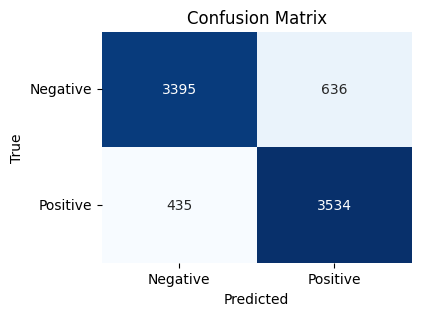

250/250 [==============================] - 1s 3ms/step


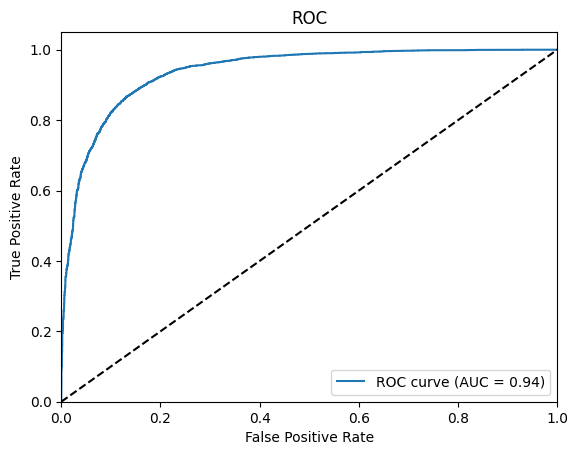

Accuracy: 0.8661, Precision: 0.8475, Recall: 0.8904, F1: 0.8684, AUC: 0.9392


In [20]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/movie_train.csv')
test_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/movie_test.csv')

train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)

# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(train_data['text'])
tokenizer = loaded_tokenizer
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

y_train = train_data['label'].values
y_test = test_data['label'].values

model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)
predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")


In [21]:
### SAVE
import pickle

# with open('movie_tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('lstm_movie')

### LOAD
# from tensorflow.keras.models import load_model

# with open('movie_tokenizer.pickle', 'rb') as handle:
#     loaded_tokenizer = pickle.load(handle)

lstm_model = load_model('lstm_movie')

In [22]:
!zip -r /content/lstm_movie.zip /content/lstm_movie

  adding: content/lstm_movie/ (stored 0%)
  adding: content/lstm_movie/saved_model.pb (deflated 89%)
  adding: content/lstm_movie/assets/ (stored 0%)
  adding: content/lstm_movie/variables/ (stored 0%)
  adding: content/lstm_movie/variables/variables.index (deflated 60%)
  adding: content/lstm_movie/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/lstm_movie/fingerprint.pb (stored 0%)
  adding: content/lstm_movie/keras_metadata.pb (deflated 86%)


In [23]:
# Test random string for LSTM

test_string_positive = '''
first trailer film viewed , curious angle storyline would take . plot one 's childhood self return present leaves open many options . Bruce Willis however superb job role given . surprised see well could act part . also good career move many others said seeing agree . film mainly remembering kid used , coming realization n't adult planned . wonderful story gripping tale makes us think . Usually scorn `` ... '' movies . example , Waterworld attempted answer question `` world covered water ... ? '' truthfully , nobody cared . movie however effects everyone theatre . True , young children may fully grasp idea growing dreams fizzle away , leaves great impact adults parents children . movie definitely worth seeing . Although , better second time around wo n't thinking much ( kid got , stuff ) relax fun . take something leave cinema . Take piece childhood 've forgotten enjoy .'''

test_string_negative = '''
m Iraq right job gives plenty time watching movies . also access plenty pirated movies , gem came along 11 movies , easily worst 've seen long time . 've seen reviews claim movie n't take seriously , really , think 's cover fact horrible . 's tongue cheek , writers really thought improving movie Blade . movie one notch Vampire Assassin , n't seen , recommend . least movie unbelievably bad 'll laugh harder thought possible . right cusp redeeming qualities ever . bad acting , cliché visual ( ie opening credits ) , adobe premier special effects . could n't even get blanks guns , may movie filmed , 're going use effects , make close accurate . cast , seems like went tae bo class picked first ugly chick walked . , like Ron Hall Vampire Assassin , n't let stunt folk act , ca n't . Also , comment `` return old vampire movies '' ... , 's . exactly new vampire movies . Buffy Vampire Slayer , Blade , Underworld , 're super star fighting vampires . newest vampire genre , bad blood , fake screams , cheesy acting . obviously anyone wrote good review somehow connected movie , friends cast . care , paid 33 cents . Anyway , wrap , someone first semester film school decided make movie , give credit 's better could . course also know ca n't make movies n't try . know watch movies though . work 12 hour nights , 6 days week , 've seen several thousand year 've bad half way hoping mortar attack .
'''

print("test_string_positive")
satire_input_x = adhoc_test_x(test_string_positive, loaded_tokenizer)
print(lstm_model.predict(satire_input_x).ravel())

print("test_string_negative")
reliable_input_x = adhoc_test_x(test_string_negative, loaded_tokenizer)
print(lstm_model.predict(reliable_input_x).ravel())

test_string_positive
1/1 [==============================] - 0s 400ms/step
[0.9962374]
test_string_negative
1/1 [==============================] - 0s 21ms/step
[0.02817418]


## BiLSTM + CNN

Epoch 1/5
200/200 [==============================] - 23s 96ms/step - loss: 0.4521 - accuracy: 0.7689 - val_loss: 0.3129 - val_accuracy: 0.8716
Epoch 2/5
200/200 [==============================] - 11s 58ms/step - loss: 0.2351 - accuracy: 0.9090 - val_loss: 0.3012 - val_accuracy: 0.8781
Epoch 3/5
200/200 [==============================] - 8s 41ms/step - loss: 0.1750 - accuracy: 0.9372 - val_loss: 0.3079 - val_accuracy: 0.8739
Epoch 4/5
200/200 [==============================] - 6s 32ms/step - loss: 0.1420 - accuracy: 0.9520 - val_loss: 0.3444 - val_accuracy: 0.8697
Epoch 5/5
250/250 [==============================] - 2s 6ms/step


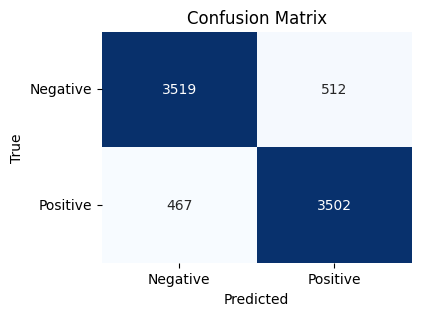

250/250 [==============================] - 2s 7ms/step


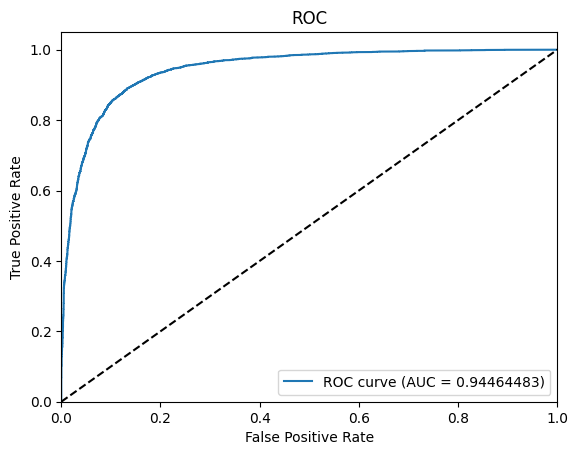

Accuracy: 0.8776, Precision: 0.8724, Recall: 0.8823, F1: 0.8774, AUC: 0.9446


In [24]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/movie_train.csv')
test_data = pd.read_csv('/content/gdrive/MyDrive/NTU mods/EE6405/Project/movie_test.csv')

train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)

# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(train_data['text'])
tokenizer = loaded_tokenizer
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

y_train = train_data['label'].values
y_test = test_data['label'].values

model = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=100),
    SpatialDropout1D(0.2),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)
predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)
plt.show()

y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.8f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")


In [28]:
### SAVE
import pickle

# with open('movie_tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('bilstm_cnn_movie')

### LOAD
# from tensorflow.keras.models import load_model

# with open('movie_tokenizer.pickle', 'rb') as handle:
#     loaded_tokenizer = pickle.load(handle)

bilstm_cnn_model = load_model('bilstm_cnn_movie')

In [29]:
!zip -r /content/bilstm_cnn_movie.zip /content/bilstm_cnn_movie

updating: content/bilstm_cnn_movie/ (stored 0%)
updating: content/bilstm_cnn_movie/saved_model.pb (deflated 91%)
updating: content/bilstm_cnn_movie/assets/ (stored 0%)
updating: content/bilstm_cnn_movie/variables/ (stored 0%)
updating: content/bilstm_cnn_movie/variables/variables.index (deflated 64%)
updating: content/bilstm_cnn_movie/variables/variables.data-00000-of-00001 (deflated 8%)
updating: content/bilstm_cnn_movie/fingerprint.pb (stored 0%)
updating: content/bilstm_cnn_movie/keras_metadata.pb (deflated 90%)


In [30]:
# Test random string for Bilstm cnn

test_string_positive = '''
first trailer film viewed , curious angle storyline would take . plot one 's childhood self return present leaves open many options . Bruce Willis however superb job role given . surprised see well could act part . also good career move many others said seeing agree . film mainly remembering kid used , coming realization n't adult planned . wonderful story gripping tale makes us think . Usually scorn `` ... '' movies . example , Waterworld attempted answer question `` world covered water ... ? '' truthfully , nobody cared . movie however effects everyone theatre . True , young children may fully grasp idea growing dreams fizzle away , leaves great impact adults parents children . movie definitely worth seeing . Although , better second time around wo n't thinking much ( kid got , stuff ) relax fun . take something leave cinema . Take piece childhood 've forgotten enjoy .'''

test_string_negative = '''
m Iraq right job gives plenty time watching movies . also access plenty pirated movies , gem came along 11 movies , easily worst 've seen long time . 've seen reviews claim movie n't take seriously , really , think 's cover fact horrible . 's tongue cheek , writers really thought improving movie Blade . movie one notch Vampire Assassin , n't seen , recommend . least movie unbelievably bad 'll laugh harder thought possible . right cusp redeeming qualities ever . bad acting , cliché visual ( ie opening credits ) , adobe premier special effects . could n't even get blanks guns , may movie filmed , 're going use effects , make close accurate . cast , seems like went tae bo class picked first ugly chick walked . , like Ron Hall Vampire Assassin , n't let stunt folk act , ca n't . Also , comment `` return old vampire movies '' ... , 's . exactly new vampire movies . Buffy Vampire Slayer , Blade , Underworld , 're super star fighting vampires . newest vampire genre , bad blood , fake screams , cheesy acting . obviously anyone wrote good review somehow connected movie , friends cast . care , paid 33 cents . Anyway , wrap , someone first semester film school decided make movie , give credit 's better could . course also know ca n't make movies n't try . know watch movies though . work 12 hour nights , 6 days week , 've seen several thousand year 've bad half way hoping mortar attack .
'''

print("test_string_positive")
satire_input_x = adhoc_test_x(test_string_positive, loaded_tokenizer)
print(bilstm_cnn_model.predict(satire_input_x).ravel())

print("test_string_negative")
reliable_input_x = adhoc_test_x(test_string_negative, loaded_tokenizer)
print(bilstm_cnn_model.predict(reliable_input_x).ravel())

test_string_positive
1/1 [==============================] - 1s 820ms/step
[0.9895455]
test_string_negative
1/1 [==============================] - 0s 21ms/step
[0.00401317]
